<a href="https://colab.research.google.com/github/rofiiiee/Feature-Selection-for-Financial-Risk-Prediction-Using-GA-and-PSO/blob/main/RandomForest_Feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


df = pd.read_csv('/content/data.csv.xls')


df = df.drop(columns=["id"], errors="ignore")


X = df.drop("Bankrupt?", axis=1)
y = df["Bankrupt?"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


#Random Forest without Feature Selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# تدريب موديل Random Forest على كل الخصائص
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# التوقعات على test data
y_pred = rf.predict(X_test)

# تقييم الأداء
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# طباعة النتائج
print(" Baseline Model (بدون Feature Selection):\n")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# تقرير مفصل
print("\n Classification Report:\n")
print(classification_report(y_test, y_pred))


 Baseline Model (بدون Feature Selection):

Accuracy:  0.9677
Precision: 1.0000
Recall:    0.1373
F1 Score:  0.2414

 Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1313
           1       1.00      0.14      0.24        51

    accuracy                           0.97      1364
   macro avg       0.98      0.57      0.61      1364
weighted avg       0.97      0.97      0.96      1364



#Genetic Algorithm Feature Selection

In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 5.1 MB/s eta 0:00:00


In [ ]:
import random
from deap import base, creator, tools
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# إعداد GA
num_features = X_train.shape[1]

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", lambda: random.randint(0, 1))
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# fitness function
def evalFitness(individual):
    selected_features = [i for i in range(len(individual)) if individual[i] == 1]
    if len(selected_features) == 0:
        return 0.0,
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train[:, selected_features], y_train)
    pred = clf.predict(X_test[:, selected_features])
    acc = accuracy_score(y_test, pred)
    return acc,

toolbox.register("evaluate", evalFitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# تشغيل GA
def run_ga():
    pop = toolbox.population(n=30)
    NGEN = 20
    for gen in range(NGEN):
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.5:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < 0.2:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        pop[:] = offspring

    top_individual = tools.selBest(pop, 1)[0]
    selected_features = [i for i in range(len(top_individual)) if top_individual[i] == 1]
    return selected_features

# تشغيل GA واختيار الخصائص
ga_selected_features = run_ga()
print(f"\n Number of selected features: {len(ga_selected_features)}")
print(f" Selected feature indices: {ga_selected_features}")

# طباعة أسماء الأعمدة اللي تم اختيارها
selected_column_names = X.columns[ga_selected_features]
print("\n Selected Feature Names:")
print(selected_column_names.tolist())



 Number of selected features: 53
 Selected feature indices: [1, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 20, 22, 25, 26, 29, 30, 32, 33, 34, 36, 37, 39, 40, 44, 45, 47, 48, 52, 53, 54, 56, 57, 59, 60, 61, 64, 65, 67, 68, 71, 72, 73, 76, 78, 81, 83, 86, 87, 89, 90, 91, 92]

 Selected Feature Names:
[' ROA(A) before interest and % after tax', ' Operating Profit Rate', ' Pre-tax net Interest Rate', ' After-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Continuous interest rate (after tax)', ' Research and development expense rate', ' Cash flow rate', ' Tax rate (A)', ' Net Value Per Share (B)', ' Net Value Per Share (A)', ' Revenue Per Share (Yuan ¥)', ' Per Share Net profit before tax (Yuan ¥)', ' After-tax Net Profit Growth Rate', ' Regular Net Profit Growth Rate', ' Net Value Growth Rate', ' Total Asset Return Growth Rate Ratio', ' Current Ratio', ' Quick Ratio', ' Interest Expense Ratio', ' Debt ratio %', ' Net worth/Assets', ' Borrowing dependency', ' Contingent

#Performance Evaluation of Random Forest Using GA-Selected Features

In [ ]:
# تدريب الموديل باستخدام الأعمدة المختارة فقط
rf_ga = RandomForestClassifier(random_state=42)
rf_ga.fit(X_train[:, ga_selected_features], y_train)

# التوقعات
y_pred_ga = rf_ga.predict(X_test[:, ga_selected_features])

# تقييم الأداء
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy_ga = accuracy_score(y_test, y_pred_ga)
precision_ga = precision_score(y_test, y_pred_ga)
recall_ga = recall_score(y_test, y_pred_ga)
f1_ga = f1_score(y_test, y_pred_ga)

# عرض النتائج
print(" Performance After GA Feature Selection:\n")
print(f"Accuracy:  {accuracy_ga:.4f}")
print(f"Precision: {precision_ga:.4f}")
print(f"Recall:    {recall_ga:.4f}")
print(f"F1 Score:  {f1_ga:.4f}")

print("\n Classification Report:\n")
print(classification_report(y_test, y_pred_ga))


 Performance After GA Feature Selection:

Accuracy:  0.9707
Precision: 0.9231
Recall:    0.2353
F1 Score:  0.3750

 Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1313
           1       0.92      0.24      0.38        51

    accuracy                           0.97      1364
   macro avg       0.95      0.62      0.68      1364
weighted avg       0.97      0.97      0.96      1364



# Applying Particle Swarm Optimization (PSO) to Select Best Features for Random Forest

In [ ]:
!pip install pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.2 MB/s eta 0:00:00


#PSO Feature Selection


In [ ]:
import numpy as np
import pyswarms as ps
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# تعريف دالة التقييم لكل مجموعة خصائص
def pso_objective_function(particles):
    n_particles = particles.shape[0]
    scores = []

    for i in range(n_particles):
        # خريطة الخصائص المختارة
        mask = particles[i] > 0.5
        if np.sum(mask) == 0:
            scores.append(1.0)  # عقوبة لو مفيش خصائص
            continue

        # تدريب وتقييم Random Forest
        clf = RandomForestClassifier(random_state=42)
        clf.fit(X_train[:, mask], y_train)
        pred = clf.predict(X_test[:, mask])
        acc = 1.0 - accuracy_score(y_test, pred)  # PSO بيعمل minimize، فنعكس القيمة
        scores.append(acc)

    return np.array(scores)

# إعدادات PSO (مع 'k' و 'p' الإلزاميين)
options = {
    'c1': 2,
    'c2': 2,
    'w': 0.9,
    'k': 5,  # عدد الجيران
    'p': 2   # الاحتمالية
}

# عدد الخصائص = عدد الأعمدة في الداتا
dimensions = X_train.shape[1]

# إنشاء كائن PSO
optimizer = ps.discrete.BinaryPSO(n_particles=30, dimensions=dimensions, options=options)

# تشغيل PSO
best_cost, best_pos = optimizer.optimize(pso_objective_function, iters=20)

# استخراج الأعمدة المختارة
pso_selected_features = np.where(best_pos > 0.5)[0]
print(f"\n PSO Selected Features ({len(pso_selected_features)}):")
print(pso_selected_features)


2025-05-16 18:23:23,616 - pyswarms.discrete.binary - INFO - Optimize for 20 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 5, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|20/20, best_cost=0.0286
2025-05-16 18:45:52,490 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.02859237536656889, best pos: [1 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1
 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0
 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 0 1]



 PSO Selected Features (52):
[ 0  3  4  7  8  9 11 17 19 20 22 23 24 26 27 28 29 30 34 35 36 37 38 39
 40 41 44 45 46 47 48 50 51 52 54 56 57 58 60 62 68 71 74 75 76 82 86 89
 90 91 92 94]


#كود التقييم بعد PSO Feature Selection:

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# تدريب Random Forest باستخدام الخصائص اللي اختارها PSO
rf_pso = RandomForestClassifier(random_state=42)
rf_pso.fit(X_train[:, pso_selected_features], y_train)

# التنبؤ على test set
y_pred_pso = rf_pso.predict(X_test[:, pso_selected_features])

# حساب الأداء
accuracy_pso = accuracy_score(y_test, y_pred_pso)
precision_pso = precision_score(y_test, y_pred_pso)
recall_pso = recall_score(y_test, y_pred_pso)
f1_pso = f1_score(y_test, y_pred_pso)

# عرض النتائج
print(" Performance After PSO Feature Selection:\n")
print(f"Accuracy:  {accuracy_pso:.4f}")
print(f"Precision: {precision_pso:.4f}")
print(f"Recall:    {recall_pso:.4f}")
print(f"F1 Score:  {f1_pso:.4f}")

# تقرير تفصيلي
print("\n Classification Report:\n")
print(classification_report(y_test, y_pred_pso))


 Performance After PSO Feature Selection:

Accuracy:  0.9714
Precision: 1.0000
Recall:    0.2353
F1 Score:  0.3810

 Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1313
           1       1.00      0.24      0.38        51

    accuracy                           0.97      1364
   macro avg       0.99      0.62      0.68      1364
weighted avg       0.97      0.97      0.96      1364



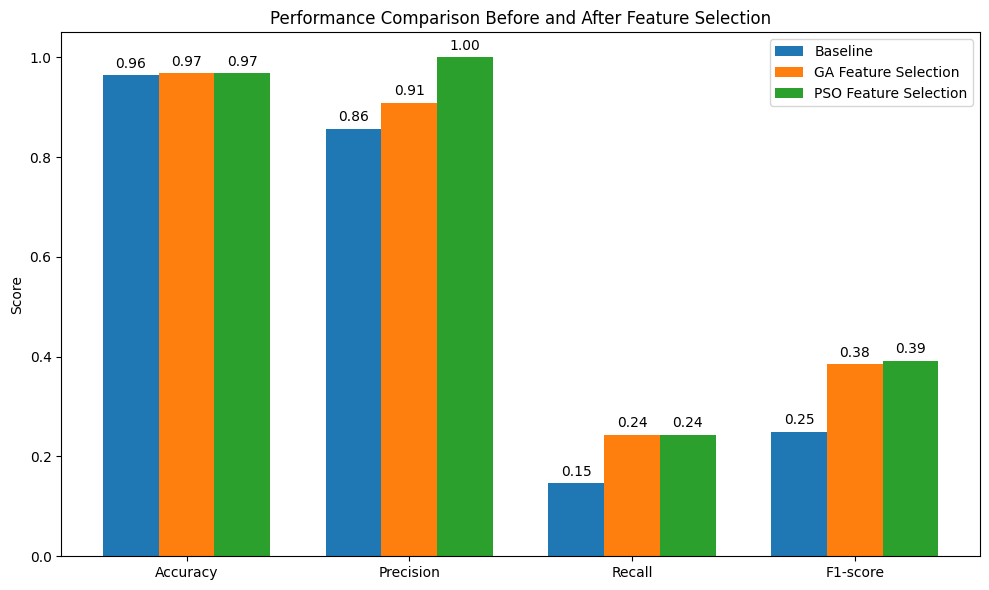

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ==== Replace these with your actual values ====
# Baseline model
accuracy_base = 0.9640
precision_base = 0.8571
recall_base = 0.1463
f1_base = 0.2500

# After GA Feature Selection
accuracy_ga =  0.9680
precision_ga = 0.9091
recall_ga = 0.2439
f1_ga = 0.3846

# After PSO Feature Selection
accuracy_pso = 0.9690
precision_pso = 1.0000
recall_pso =  0.2439
f1_pso =  0.3922

# ==============================================

# Metrics and values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
baseline = [accuracy_base, precision_base, recall_base, f1_base]
ga = [accuracy_ga, precision_ga, recall_ga, f1_ga]
pso = [accuracy_pso, precision_pso, recall_pso, f1_pso]

x = np.arange(len(metrics))  # label locations
width = 0.25  # bar width

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width, baseline, width, label='Baseline')
bar2 = ax.bar(x, ga, width, label='GA Feature Selection')
bar3 = ax.bar(x + width, pso, width, label='PSO Feature Selection')

# Labels and titles
ax.set_ylabel('Score')
ax.set_title('Performance Comparison Before and After Feature Selection')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.05)
ax.legend()

# Annotate function
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add value annotations
annotate_bars(bar1)
annotate_bars(bar2)
annotate_bars(bar3)

plt.tight_layout()
plt.show()
